In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Part 1: Data Cleaning

In [2]:
clean = pd.read_csv('clean_kaggle_data_2022.csv')
description = clean.iloc[0,:]  #store the description of questions into series named'description'.
clean=clean.iloc[1:,:]    #get rid of the first row describing questions
salary_dic = dict(zip(clean.Q29_Encoded,clean.Q29_buckets))   #store the code of salary as key, bucket as values

clean.drop(columns =['Duration (in seconds)','Q29_buckets','Q29'],inplace=True)   #no longer interese about Duration
clean

/var/folders/43/nrds9n3n523d8m2b4m6bh0480000gn/T/ipykernel_61040/4073424919.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  clean = pd.read_csv('clean_kaggle_data_2022.csv')


,Q2,Q3,Q4,Q5,Q6_1,Q6_2,Q6_3,Q6_4,Q6_5,Q6_6,...,Q44_4,Q44_5,Q44_6,Q44_7,Q44_8,Q44_9,Q44_10,Q44_11,Q44_12,Q29_Encoded
1,55-59,Man,France,No,Coursera,NaN,Kaggle Learn Courses,NaN,NaN,NaN,...,"Kaggle (notebooks, forums, etc)","Course Forums (forums.fast.ai, Coursera forums...",NaN,NaN,"Blogs (Towards Data Science, Analytics Vidhya,...",NaN,NaN,NaN,NaN,2.0
2,30-34,Man,Germany,No,Coursera,edX,NaN,NaN,NaN,Udacity,...,NaN,NaN,"YouTube (Kaggle YouTube, Cloud AI Adventures, ...",NaN,"Blogs (Towards Data Science, Analytics Vidhya,...",NaN,NaN,NaN,NaN,10.0
3,70+,Man,Australia,No,Coursera,NaN,Kaggle Learn Courses,NaN,NaN,NaN,...,NaN,NaN,NaN,"Podcasts (Chai Time Data Science, O’Reilly Dat...",NaN,NaN,NaN,NaN,NaN,10.0
4,40-44,Man,United States of America,No,Coursera,NaN,Kaggle Learn Courses,NaN,Fast.ai,Udacity,...,NaN,NaN,NaN,"Podcasts (Chai Time Data Science, O’Reilly Dat...","Blogs (Towards Data Science, Analytics Vidhya,...",NaN,NaN,NaN,NaN,13.0
5,40-44,Man,United States of America,No,Coursera,NaN,NaN,NaN,NaN,Udacity,...,NaN,NaN,NaN,"Podcasts (Chai Time Data Science, O’Reilly Dat...","Blogs (Towards Data Science, Analytics Vidhya,...","Journal Publications (peer-reviewed journals, ...",NaN,NaN,NaN,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8132,40-44,Man,United States of America,No,NaN,NaN,Kaggle Learn Courses,DataCamp,NaN,NaN,...,"Kaggle (notebooks, forums, etc)",NaN,"YouTube (Kaggle YouTube, Cloud AI Adventures, ...",NaN,"Blogs (Towards Data Science, Analytics Vidhya,...",NaN,NaN,NaN,NaN,10.0
8133,35-39,Man,India,No,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,"YouTube (Kaggle YouTube, Cloud AI Adventures, ...",NaN,NaN,NaN,NaN,NaN,NaN,0.0
8134,40-44,Man,India,No,NaN,NaN,NaN,DataCamp,NaN,NaN,...,NaN,NaN,"YouTube (Kaggle YouTube, Cloud AI Adventures, ...",NaN,NaN,NaN,NaN,NaN,NaN,0.0
8135,25-29,Man,Turkey,No,NaN,NaN,NaN,DataCamp,NaN,NaN,...,"Kaggle (notebooks, forums, etc)",NaN,"YouTube (Kaggle YouTube, Cloud AI Adventures, ...",NaN,NaN,NaN,NaN,NaN,NaN,2.0


In [3]:
clean.info()   #all columns except Q29_Encoded have 'object' datatype

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8136 entries, 1 to 8136
Columns: 295 entries, Q2 to Q29_Encoded
dtypes: float64(1), object(294)
memory usage: 18.3+ MB


## Firstly, handle missing values:

Columns contain missing value:
 True     283
False     12
dtype: int64

Q29_Encoded contains missing value? False


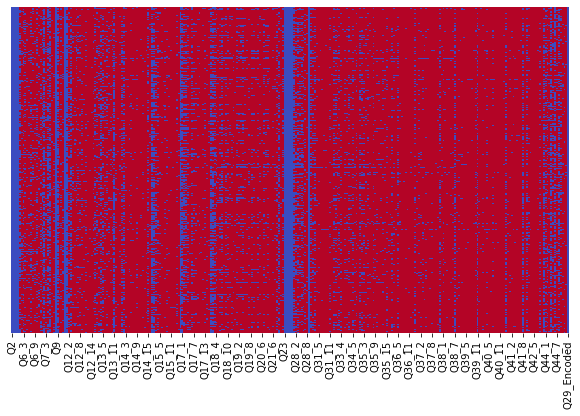

In [4]:
# lets see number of missing data using a heatmap.
fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(clean.isnull(), cmap='coolwarm', yticklabels=False, cbar=False, ax=ax)
print("Columns contain missing value:\n",clean.isnull().any().value_counts())
print("\nQ29_Encoded contains missing value?", clean.Q29_Encoded.isnull().any())

# 283 out of 295 columns contain the missing values, Encoded Salary do not have any missing value. 

### Deal with questions which contains multiple columns.
By obersving the original data, I found the appearance of most of missing data is because they just did not select the option instead of no repsonse for the question. So here we deal with them first. By observing the dataset, found they contains '_'  in the column names.

In [5]:
#separate the multi-selecting questions and other categorical-data questions

input_q = clean.columns.values[:-1]         #all question names
multi_select_q = clean.filter(regex='_',axis=1).columns.values[:-1]    #mutilple-slestion question names 
other_q = np.setdiff1d(input_q, multi_select_q)     #other categorical-data questions
print('Seperate well?',len(other_q)+len(multi_select_q) == len(clean.columns[:-1]))

Seperate well? True


In [6]:
# convert the answers of multiple-choice questions to 0 or 1. (1 if being selected)
for i in multi_select_q:
    clean.loc[:,i]=clean.loc[:,i].notnull().astype(int)
    
print('There are {} missing value under multiple-choice questions.'.format(
    clean.loc[:,multi_select_q].isnull().sum().sum()))

clean.head()

There are 0 missing value under multiple-choice questions.


,Q2,Q3,Q4,Q5,Q6_1,Q6_2,Q6_3,Q6_4,Q6_5,Q6_6,...,Q44_4,Q44_5,Q44_6,Q44_7,Q44_8,Q44_9,Q44_10,Q44_11,Q44_12,Q29_Encoded
1,55-59,Man,France,No,1,0,1,0,0,0,...,1,1,0,0,1,0,0,0,0,2.0
2,30-34,Man,Germany,No,1,1,0,0,0,1,...,0,0,1,0,1,0,0,0,0,10.0
3,70+,Man,Australia,No,1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,10.0
4,40-44,Man,United States of America,No,1,0,1,0,1,1,...,0,0,0,1,1,0,0,0,0,13.0
5,40-44,Man,United States of America,No,1,0,0,0,0,1,...,0,0,0,1,1,1,0,0,0,13.0


### #Deal with other questions. (one column for each question)

In [7]:
temp = clean.loc[:,other_q].isnull().sum()  #check the questions which contain missing values
otherq_with_na= temp[temp>0]
print("Counts of Missing values in other questions:\n", otherq_with_na)

Counts of Missing values in other questions:
 Q16     684
Q22    6522
Q30      50
Q32    6275
Q43    3723
Q9     2941
dtype: int64


In [8]:
# There are two many missing values for Q23 and Q32, may consider drop them
# show the description of the questions with missing values first
pd.set_option('display.max_colwidth', None)
description[otherq_with_na.index].to_frame().rename(columns={0:'description'})

,description
Q16,For how many years have you used machine learning methods?
Q22,Which of the following ML model hubs/repositories do you use most often? - Selected Choice
Q30,Approximately how much money have you spent on machine learning and/or cloud computing services at home or at work in the past 5 years (approximate $USD)?\n (approximate $USD)?
Q32,"Of the cloud platforms that you are familiar with, which has the best developer experience (most enjoyable to use)? - Selected Choice"
Q43,Approximately how many times have you used a TPU (tensor processing unit)?
Q9,"Have you ever published any academic research (papers, preprints, conference proceedings, etc)?"


#### possible reasons for missing values, for non-selecting questions:

* For Q43: Participants may don't remember the times of using TPU.
* For Q32: Hard to decide which cloud platforms is the best.
* For Q22: Hard to say which ML model hubs is uesed most often for them.
* For Q9: The defination of academic research may be ambiguous.
* For Q16: Hard to decide the years of using machine learning methods.
* For Q30: Not sure about money used.

In [9]:
# see the distributions of the answers
for q in ['Q43', 'Q32', 'Q22', 'Q9', 'Q16', 'Q30']:
    print(clean.loc[:,q].value_counts().sort_values(ascending = False),'\n')

Never                 2429
2-5 times              922
Once                   586
6-25 times             255
More than 25 times     221
Name: Q43, dtype: int64 

 Amazon Web Services (AWS)                                 537
 Google Cloud Platform (GCP)                               488
They all had a similarly enjoyable developer experience    431
 Microsoft Azure                                           241
None were satisfactory                                      66
 IBM Cloud / Red Hat                                        34
 Oracle Cloud                                               19
Other                                                       19
 VMware Cloud                                               11
 SAP Cloud                                                   7
 Alibaba Cloud                                               4
 Tencent Cloud                                               3
 Huawei Cloud                                                1
Name: Q32, dtype: in

* Notice for Q22,"Which of the following ML model hubs/repositories do you use most often" : the mojority uses Kaggle datasets, but this is an survey conducetd by Kaggle so the answer may be unfair, and many data missing for this quesiton. Drop this question.

In [10]:
# fill the missing data
clean.drop(columns = ['Q22','Q32'],inplace = True) #6275/8136 unknown for Q22, and 6522/8136 unknown for Q32, drop columns
clean.Q43.fillna(clean.Q43.mode()[0],inplace=True)   # missing values may be attributed to the unfamilar with TPU, fill with mode
clean.Q9.fillna('Unknown',inplace=True)      #replace nan of any academic research published to 'Unknown'
clean.Q16.fillna(clean.Q16.mode()[0],inplace=True)
clean.Q30.fillna(clean.Q30.mode()[0],inplace=True)  #fill with mode of spending
print("Done with all the missing values? ", clean.isnull().sum().sum() == 0)
clean.head()

Done with all the missing values?  True


,Q2,Q3,Q4,Q5,Q6_1,Q6_2,Q6_3,Q6_4,Q6_5,Q6_6,...,Q44_4,Q44_5,Q44_6,Q44_7,Q44_8,Q44_9,Q44_10,Q44_11,Q44_12,Q29_Encoded
1,55-59,Man,France,No,1,0,1,0,0,0,...,1,1,0,0,1,0,0,0,0,2.0
2,30-34,Man,Germany,No,1,1,0,0,0,1,...,0,0,1,0,1,0,0,0,0,10.0
3,70+,Man,Australia,No,1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,10.0
4,40-44,Man,United States of America,No,1,0,1,0,1,1,...,0,0,0,1,1,0,0,0,0,13.0
5,40-44,Man,United States of America,No,1,0,0,0,0,1,...,0,0,0,1,1,1,0,0,0,13.0


## Secondly, convert categorical data into numerical data by encoding:



In [11]:
# Dealing with categorical data with ordinal records.
clean['Q8'].replace({'I prefer not to answer' : clean['Q8'].mode().values}, inplace=True)  #replace no-answer to mode

#store the answers in order
Q2_sort = sorted(list(clean.Q2.unique()))
Q8_sort = ['No formal education past high school',
           'Some college/university study without earning a bachelor’s degree','Bachelor’s degree', 
           'Master’s degree', 'Professional doctorate','Doctoral degree']
Q11_sort = ['I have never written code', '< 1 years','1-3 years', '3-5 years', '5-10 years','10-20 years', '20+ years']
Q16_sort = ['I do not use machine learning methods', 'Under 1 year',
            '1-2 years', '2-3 years', '3-4 years', '4-5 years', '5-10 years','10-20 years']
Q25_sort = ['0-49 employees', '50-249 employees','250-999 employees','1000-9,999 employees','10,000 or more employees']
Q26_sort = ['0', '1-2','3-4', '5-9','10-14', '15-19', '20+']
Q30_sort = ['$0 ($USD)', '$1-$99', '$100-$999', '$1000-$9,999','$10,000-$99,999', '$100,000 or more ($USD)']
Q43_sort = ['Never', 'Once','2-5 times', '6-25 times', 'More than 25 times']
ordinal = [Q2_sort,Q8_sort,Q11_sort,Q16_sort,Q25_sort,Q26_sort,Q30_sort,Q43_sort]

In [12]:
#encode the ordinal data of the questions above
from sklearn.preprocessing import OrdinalEncoder
n=0
for q in ['Q2', 'Q8', 'Q11', 'Q16', 'Q25','Q26', 'Q30', 'Q43']:
    OE = OrdinalEncoder(categories = [ordinal[n]])
    clean[q] = OE.fit_transform(clean[q].values.reshape(-1,1))
    n+=1

#check the encoded 'Q2', 'Q8', 'Q11', 'Q16', 'Q25','Q26', 'Q30', 'Q43'
clean[['Q2', 'Q8', 'Q11', 'Q16', 'Q25','Q26', 'Q30', 'Q43']].dtypes

Q2     float64
Q8     float64
Q11    float64
Q16    float64
Q25    float64
Q26    float64
Q30    float64
Q43    float64
dtype: object

In [13]:
# show the other columns, not encoded yet
clean.loc[:,clean.dtypes == object].head()

,Q3,Q4,Q5,Q9,Q23,Q24,Q27
1,Man,France,No,Unknown,Data Scientist,Online Service/Internet-based Services,"We recently started using ML methods (i.e., models in production for less than 2 years)"
2,Man,Germany,No,Unknown,Software Engineer,Insurance/Risk Assessment,"We have well established ML methods (i.e., models in production for more than 2 years)"
3,Man,Australia,No,Yes,Research Scientist,Government/Public Service,"We recently started using ML methods (i.e., models in production for less than 2 years)"
4,Man,United States of America,No,Yes,Developer Advocate,Computers/Technology,"We have well established ML methods (i.e., models in production for more than 2 years)"
5,Man,United States of America,No,Yes,Data Scientist,Computers/Technology,"We have well established ML methods (i.e., models in production for more than 2 years)"


In [14]:
# Observed the Q27 may also be ordinal. Encode Q27:
clean.Q27.unique()    #check the answers of Q27

array(['We recently started using ML methods (i.e., models in production for less than 2 years)',
       'We have well established ML methods (i.e., models in production for more than 2 years)',
       'We are exploring ML methods (and may one day put a model into production)',
       'I do not know',
       'We use ML methods for generating insights (but do not put working models into production)',
       'No (we do not use ML methods)'], dtype=object)

In [15]:
clean.Q27.replace({'I do not know' : clean.Q27.mode()[0]}, inplace=True) #repalce the no-answer data to the mode

Q27_sort = ['No (we do not use ML methods)',
            'We use ML methods for generating insights (but do not put working models into production)',
            'We are exploring ML methods (and may one day put a model into production)',
            'We recently started using ML methods (i.e., models in production for less than 2 years)',
            'We have well established ML methods (i.e., models in production for more than 2 years)']
OE_27 = OrdinalEncoder(categories = [Q27_sort])
clean.Q27 = OE_27.fit_transform(clean.Q27.values.reshape(-1,1))   #encode Q27

In [16]:
# Create dummy features for the left categorical features
# Don't dummy Q5, as all answers are No, drop it later

dummies_Q3 = pd.get_dummies(clean.Q3, prefix='Q3')
dummies_Q4 = pd.get_dummies(clean.Q4, prefix='Q4')
dummies_Q23 = pd.get_dummies(clean.Q23, prefix='Q23')
dummies_Q24 = pd.get_dummies(clean.Q24, prefix='Q24')
dummies_Q9 = pd.get_dummies(clean.Q9, prefix='Q9')

# Add the new features to the dataframe via concating
temp = pd.concat([clean, dummies_Q3, dummies_Q4, dummies_Q23,dummies_Q24,dummies_Q9], axis=1)

# Drop the original categorical feature columns
tempDF = temp.drop(['Q3', 'Q4', 'Q5', 'Q23', 'Q24','Q9'],axis=1)  #As Q5 contains only 'No',also dropped
tempDF

# Drop one of each of the dummy variables because its value is implied  by the other dummy variable columns.
# E.g. If Q3_Man = 0, Q3_Woman = 0, Q3_Nonbinary=0, Q3_Prefer not to say = 0, 
# then the person is Prefer to self-describe

clean_new = tempDF.drop(['Q3_Prefer not to say','Q4_India','Q23_Other','Q24_Other','Q9_Unknown'],axis=1)
clean_new

,Q2,Q6_1,Q6_2,Q6_3,Q6_4,Q6_5,Q6_6,Q6_7,Q6_8,Q6_9,...,Q24_Insurance/Risk Assessment,Q24_Manufacturing/Fabrication,Q24_Marketing/CRM,Q24_Medical/Pharmaceutical,Q24_Non-profit/Service,Q24_Online Service/Internet-based Services,Q24_Retail/Sales,Q24_Shipping/Transportation,Q9_No,Q9_Yes
1,8.0,1,0,1,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
2,3.0,1,1,0,0,0,1,1,0,0,...,1,0,0,0,0,0,0,0,0,0
3,10.0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,5.0,1,0,1,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
5,5.0,1,0,0,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8132,5.0,0,0,1,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,1,0
8133,4.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
8134,5.0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8135,2.0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [17]:
clean_new.dtypes.unique()  #check the data type of the new df, non-categorical

array([dtype('float64'), dtype('int64'), dtype('uint8')], dtype=object)

# Part 2: Exploratory data analysis and feature selection

<AxesSubplot:xlabel='Q29_Encoded', ylabel='count'>

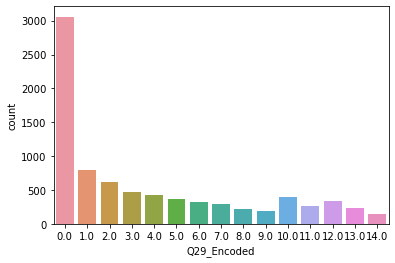

In [18]:
# see the distribution of encoded salary, Q29_Encoded
sns.countplot(x='Q29_Encoded',data=clean_new)

### Lasso Regularization

In [19]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso

In [20]:
X = clean_new.drop(['Q29_Encoded'], axis = 1)
y = clean_new['Q29_Encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)   #30% test data, 70% tarin data
print("There are {} in training dataset.".format(X_train.shape[0]))

There are 5695 in training dataset.


In [21]:
# optimize its hyperparameter and train it on the training dataset
# based : https://towardsdatascience.com/feature-selection-in-machine-learning-using-lasso-regression-7809c7c2771a
pipeline = Pipeline([('model',Lasso())])
#optimize the α hyperparameter of Lasso regression, by test several values from 0.1 to 10 with 0.1 step
search = GridSearchCV(pipeline,{'model__alpha':np.arange(0.1,10,0.1)},cv = 10,   
                      scoring="neg_mean_squared_error",verbose=3)   #minimize the mean squared error
search.fit(X_train,y_train)

Fitting 10 folds for each of 99 candidates, totalling 990 fits
[CV 1/10] END ................model__alpha=0.1;, score=-8.970 total time=   0.1s
[CV 2/10] END ................model__alpha=0.1;, score=-7.790 total time=   0.0s
[CV 3/10] END ................model__alpha=0.1;, score=-9.116 total time=   0.0s
[CV 4/10] END ................model__alpha=0.1;, score=-8.520 total time=   0.0s
[CV 5/10] END ...............model__alpha=0.1;, score=-10.297 total time=   0.0s
[CV 6/10] END ................model__alpha=0.1;, score=-8.392 total time=   0.0s
[CV 7/10] END ................model__alpha=0.1;, score=-9.798 total time=   0.0s
[CV 8/10] END ................model__alpha=0.1;, score=-7.465 total time=   0.0s
[CV 9/10] END ...............model__alpha=0.1;, score=-10.722 total time=   0.0s
[CV 10/10] END ...............model__alpha=0.1;, score=-7.946 total time=   0.0s
[CV 1/10] END ................model__alpha=0.2;, score=-9.384 total time=   0.0s
[CV 2/10] END ................model__alpha=0.2

[CV 1/10] END model__alpha=1.2000000000000002;, score=-14.572 total time=   0.0s
[CV 2/10] END model__alpha=1.2000000000000002;, score=-13.514 total time=   0.0s
[CV 3/10] END model__alpha=1.2000000000000002;, score=-14.086 total time=   0.0s
[CV 4/10] END model__alpha=1.2000000000000002;, score=-14.390 total time=   0.0s
[CV 5/10] END model__alpha=1.2000000000000002;, score=-15.215 total time=   0.0s
[CV 6/10] END model__alpha=1.2000000000000002;, score=-14.717 total time=   0.0s
[CV 7/10] END model__alpha=1.2000000000000002;, score=-16.634 total time=   0.0s
[CV 8/10] END model__alpha=1.2000000000000002;, score=-13.110 total time=   0.0s
[CV 9/10] END model__alpha=1.2000000000000002;, score=-16.492 total time=   0.0s
[CV 10/10] END model__alpha=1.2000000000000002;, score=-14.188 total time=   0.0s
[CV 1/10] END model__alpha=1.3000000000000003;, score=-14.766 total time=   0.0s
[CV 2/10] END model__alpha=1.3000000000000003;, score=-13.688 total time=   0.0s
[CV 3/10] END model__alpha=

[CV 9/10] END ...............model__alpha=2.2;, score=-18.306 total time=   0.0s
[CV 10/10] END ..............model__alpha=2.2;, score=-16.183 total time=   0.0s
[CV 1/10] END model__alpha=2.3000000000000003;, score=-16.618 total time=   0.0s
[CV 2/10] END model__alpha=2.3000000000000003;, score=-15.696 total time=   0.0s
[CV 3/10] END model__alpha=2.3000000000000003;, score=-15.865 total time=   0.0s
[CV 4/10] END model__alpha=2.3000000000000003;, score=-16.225 total time=   0.0s
[CV 5/10] END model__alpha=2.3000000000000003;, score=-16.693 total time=   0.0s
[CV 6/10] END model__alpha=2.3000000000000003;, score=-16.520 total time=   0.0s
[CV 7/10] END model__alpha=2.3000000000000003;, score=-18.955 total time=   0.0s
[CV 8/10] END model__alpha=2.3000000000000003;, score=-15.093 total time=   0.0s
[CV 9/10] END model__alpha=2.3000000000000003;, score=-18.488 total time=   0.0s
[CV 10/10] END model__alpha=2.3000000000000003;, score=-16.391 total time=   0.0s
[CV 1/10] END model__alpha=

[CV 7/10] END model__alpha=3.3000000000000003;, score=-20.967 total time=   0.0s
[CV 8/10] END model__alpha=3.3000000000000003;, score=-16.910 total time=   0.0s
[CV 9/10] END model__alpha=3.3000000000000003;, score=-20.363 total time=   0.0s
[CV 10/10] END model__alpha=3.3000000000000003;, score=-18.685 total time=   0.0s
[CV 1/10] END model__alpha=3.4000000000000004;, score=-18.718 total time=   0.0s
[CV 2/10] END model__alpha=3.4000000000000004;, score=-18.011 total time=   0.0s
[CV 3/10] END model__alpha=3.4000000000000004;, score=-17.896 total time=   0.0s
[CV 4/10] END model__alpha=3.4000000000000004;, score=-17.992 total time=   0.0s
[CV 5/10] END model__alpha=3.4000000000000004;, score=-18.522 total time=   0.0s
[CV 6/10] END model__alpha=3.4000000000000004;, score=-18.495 total time=   0.0s
[CV 7/10] END model__alpha=3.4000000000000004;, score=-21.128 total time=   0.0s
[CV 8/10] END model__alpha=3.4000000000000004;, score=-17.054 total time=   0.0s
[CV 9/10] END model__alpha=

[CV 5/10] END model__alpha=4.3999999999999995;, score=-18.657 total time=   0.0s
[CV 6/10] END model__alpha=4.3999999999999995;, score=-18.611 total time=   0.0s
[CV 7/10] END model__alpha=4.3999999999999995;, score=-21.217 total time=   0.0s
[CV 8/10] END model__alpha=4.3999999999999995;, score=-17.188 total time=   0.0s
[CV 9/10] END model__alpha=4.3999999999999995;, score=-20.638 total time=   0.0s
[CV 10/10] END model__alpha=4.3999999999999995;, score=-18.827 total time=   0.0s
[CV 1/10] END ...............model__alpha=4.5;, score=-18.813 total time=   0.0s
[CV 2/10] END ...............model__alpha=4.5;, score=-18.063 total time=   0.0s
[CV 3/10] END ...............model__alpha=4.5;, score=-18.006 total time=   0.0s
[CV 4/10] END ...............model__alpha=4.5;, score=-18.160 total time=   0.0s
[CV 5/10] END ...............model__alpha=4.5;, score=-18.657 total time=   0.0s
[CV 6/10] END ...............model__alpha=4.5;, score=-18.611 total time=   0.0s
[CV 7/10] END .............

[CV 9/10] END ...............model__alpha=5.4;, score=-20.638 total time=   0.0s
[CV 10/10] END ..............model__alpha=5.4;, score=-18.827 total time=   0.0s
[CV 1/10] END ...............model__alpha=5.5;, score=-18.813 total time=   0.0s
[CV 2/10] END ...............model__alpha=5.5;, score=-18.063 total time=   0.0s
[CV 3/10] END ...............model__alpha=5.5;, score=-18.006 total time=   0.0s
[CV 4/10] END ...............model__alpha=5.5;, score=-18.160 total time=   0.0s
[CV 5/10] END ...............model__alpha=5.5;, score=-18.657 total time=   0.0s
[CV 6/10] END ...............model__alpha=5.5;, score=-18.611 total time=   0.0s
[CV 7/10] END ...............model__alpha=5.5;, score=-21.217 total time=   0.0s
[CV 8/10] END ...............model__alpha=5.5;, score=-17.188 total time=   0.0s
[CV 9/10] END ...............model__alpha=5.5;, score=-20.638 total time=   0.0s
[CV 10/10] END ..............model__alpha=5.5;, score=-18.827 total time=   0.0s
[CV 1/10] END ..............

[CV 8/10] END ...............model__alpha=6.5;, score=-17.188 total time=   0.0s
[CV 9/10] END ...............model__alpha=6.5;, score=-20.638 total time=   0.0s
[CV 10/10] END ..............model__alpha=6.5;, score=-18.827 total time=   0.0s
[CV 1/10] END ...............model__alpha=6.6;, score=-18.813 total time=   0.0s
[CV 2/10] END ...............model__alpha=6.6;, score=-18.063 total time=   0.0s
[CV 3/10] END ...............model__alpha=6.6;, score=-18.006 total time=   0.0s
[CV 4/10] END ...............model__alpha=6.6;, score=-18.160 total time=   0.0s
[CV 5/10] END ...............model__alpha=6.6;, score=-18.657 total time=   0.0s
[CV 6/10] END ...............model__alpha=6.6;, score=-18.611 total time=   0.0s
[CV 7/10] END ...............model__alpha=6.6;, score=-21.217 total time=   0.0s
[CV 8/10] END ...............model__alpha=6.6;, score=-17.188 total time=   0.0s
[CV 9/10] END ...............model__alpha=6.6;, score=-20.638 total time=   0.0s
[CV 10/10] END .............

[CV 4/10] END ...............model__alpha=7.6;, score=-18.160 total time=   0.0s
[CV 5/10] END ...............model__alpha=7.6;, score=-18.657 total time=   0.0s
[CV 6/10] END ...............model__alpha=7.6;, score=-18.611 total time=   0.0s
[CV 7/10] END ...............model__alpha=7.6;, score=-21.217 total time=   0.0s
[CV 8/10] END ...............model__alpha=7.6;, score=-17.188 total time=   0.0s
[CV 9/10] END ...............model__alpha=7.6;, score=-20.638 total time=   0.0s
[CV 10/10] END ..............model__alpha=7.6;, score=-18.827 total time=   0.0s
[CV 1/10] END ...............model__alpha=7.7;, score=-18.813 total time=   0.0s
[CV 2/10] END ...............model__alpha=7.7;, score=-18.063 total time=   0.0s
[CV 3/10] END ...............model__alpha=7.7;, score=-18.006 total time=   0.0s
[CV 4/10] END ...............model__alpha=7.7;, score=-18.160 total time=   0.0s
[CV 5/10] END ...............model__alpha=7.7;, score=-18.657 total time=   0.0s
[CV 6/10] END ..............

[CV 10/10] END ..............model__alpha=8.6;, score=-18.827 total time=   0.0s
[CV 1/10] END ...............model__alpha=8.7;, score=-18.813 total time=   0.0s
[CV 2/10] END ...............model__alpha=8.7;, score=-18.063 total time=   0.0s
[CV 3/10] END ...............model__alpha=8.7;, score=-18.006 total time=   0.0s
[CV 4/10] END ...............model__alpha=8.7;, score=-18.160 total time=   0.0s
[CV 5/10] END ...............model__alpha=8.7;, score=-18.657 total time=   0.0s
[CV 6/10] END ...............model__alpha=8.7;, score=-18.611 total time=   0.0s
[CV 7/10] END ...............model__alpha=8.7;, score=-21.217 total time=   0.0s
[CV 8/10] END ...............model__alpha=8.7;, score=-17.188 total time=   0.0s
[CV 9/10] END ...............model__alpha=8.7;, score=-20.638 total time=   0.0s
[CV 10/10] END ..............model__alpha=8.7;, score=-18.827 total time=   0.0s
[CV 1/10] END ...............model__alpha=8.8;, score=-18.813 total time=   0.0s
[CV 2/10] END ..............

[CV 7/10] END .model__alpha=9.700000000000001;, score=-21.217 total time=   0.0s
[CV 8/10] END .model__alpha=9.700000000000001;, score=-17.188 total time=   0.0s
[CV 9/10] END .model__alpha=9.700000000000001;, score=-20.638 total time=   0.0s
[CV 10/10] END model__alpha=9.700000000000001;, score=-18.827 total time=   0.0s
[CV 1/10] END ...............model__alpha=9.8;, score=-18.813 total time=   0.0s
[CV 2/10] END ...............model__alpha=9.8;, score=-18.063 total time=   0.0s
[CV 3/10] END ...............model__alpha=9.8;, score=-18.006 total time=   0.0s
[CV 4/10] END ...............model__alpha=9.8;, score=-18.160 total time=   0.0s
[CV 5/10] END ...............model__alpha=9.8;, score=-18.657 total time=   0.0s
[CV 6/10] END ...............model__alpha=9.8;, score=-18.611 total time=   0.0s
[CV 7/10] END ...............model__alpha=9.8;, score=-21.217 total time=   0.0s
[CV 8/10] END ...............model__alpha=9.8;, score=-17.188 total time=   0.0s
[CV 9/10] END ..............

GridSearchCV(cv=10, estimator=Pipeline(steps=[('model', Lasso())]),
             param_grid={'model__alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2,
       5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4, 6.5,
       6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8,
       7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. , 9.1,
       9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9])},
             scoring='neg_mean_squared_error', verbose=3)

In [22]:
search.best_params_   # the best 'model__alpha' is 0.1

{'model__alpha': 0.1}

In [23]:
coefficients = search.best_estimator_.named_steps['model'].coef_   #get the values of the coefficients of Lasso regression.
importance = np.abs(coefficients)  #importance of a feature is the absolute value of its coefficient

all_fea = clean_new.columns.values
temp_np = np.delete(clean_new.columns.values, np.argwhere(all_fea == 'Q29_Encoded'))
keep_fea = temp_np[importance > 0]  #the features we want to keep
discard_fea = temp_np[importance == 0]  #the features we want to drop

df = clean_new.loc[:,keep_fea]     #select the importance>0 features
df['Q29_Encoded']= clean_new['Q29_Encoded']   #add the Q29_Encoded column
df
#keep 16 features, with Q29_Encoded.

,Q2,Q11,Q14_2,Q16,Q17_2,Q21_8,Q25,Q26,Q27,Q28_3,Q30,Q35_1,Q4_United States of America,"Q23_Manager (Program, Project, Operations, Executive-level, etc)",Q24_Academics/Education,Q29_Encoded
1,8.0,5.0,1,2.0,0,0,0.0,1.0,3.0,1,3.0,0,0,0,0,2.0
2,3.0,5.0,1,5.0,1,0,2.0,6.0,4.0,1,0.0,0,0,0,0,10.0
3,10.0,6.0,0,6.0,0,0,3.0,6.0,3.0,1,2.0,0,0,0,0,10.0
4,5.0,5.0,1,6.0,1,0,3.0,6.0,4.0,1,2.0,0,1,0,0,13.0
5,5.0,5.0,1,6.0,1,0,3.0,2.0,4.0,1,5.0,1,1,0,0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8132,5.0,5.0,1,1.0,1,0,4.0,6.0,4.0,1,0.0,0,1,0,0,10.0
8133,4.0,2.0,0,2.0,0,0,4.0,1.0,4.0,0,2.0,1,0,0,0,0.0
8134,5.0,2.0,0,0.0,0,0,0.0,0.0,0.0,0,1.0,0,0,0,0,0.0
8135,2.0,1.0,0,1.0,0,1,4.0,0.0,0.0,0,2.0,0,0,0,0,2.0


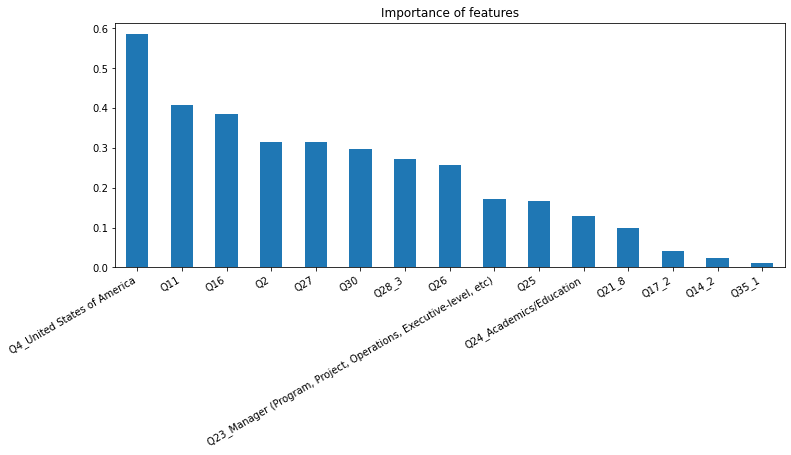

In [24]:
# visualize the importance of features with Q29_Encoded
df_cor = df.corr()
correlation = df_cor.Q29_Encoded.apply(lambda x:abs(x)).sort_values(ascending=False)

fig_imp = plt.figure(figsize=[12,5])
correlation[1:].plot(kind="bar",title="Importance of features")
fig_imp.autofmt_xdate() 
plt.show()

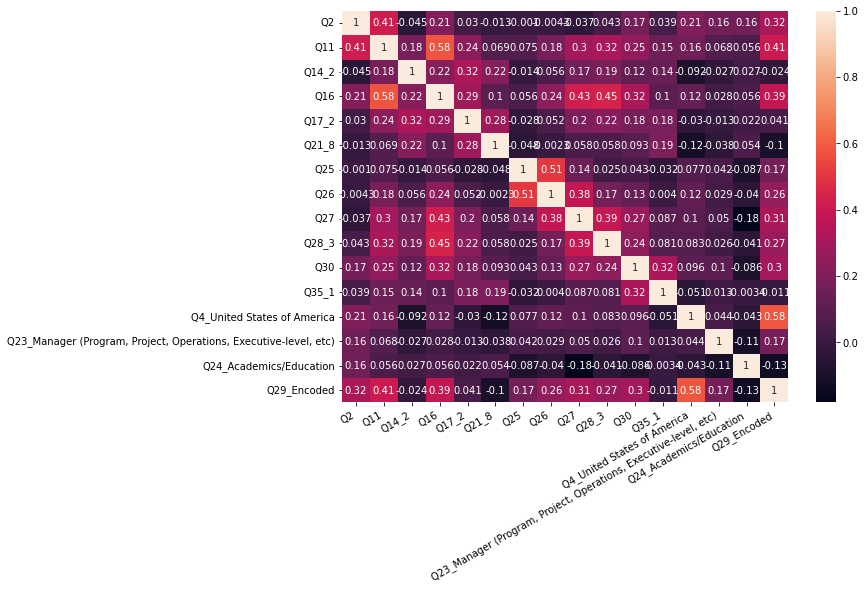

In [25]:
fig = plt.figure(figsize=(10,8))
sns.heatmap(df_cor, xticklabels = df_cor.columns, yticklabels = df_cor.columns, annot=True)
fig.autofmt_xdate() 
plt.show()

In [26]:
# check is there any denepence among the features
dependent = []    
for c in range(df_cor.shape[1]):   #for each column
    for r in np.arange(c+1,df_cor.shape[1]):  #for each row
        if abs(df_cor.iloc[r, c]) > 0.6:   #set threshold =0.6
            dependent.append([df_cor.columns[c],df_cor.index[r]])
dependent     
# show empty list of dependent pairs, so there is no dependece of the input features

[]

# Part 3: Model implementation

In [27]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, confusion_matrix
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")

### Model accuracy compared across the folds, with average and variance of accuracy for folds:

* Define a function for the prediction of bucket based on highest accuracy of belonging

In [28]:
def get_predic(X, Y, X_val, model):
    prob_df = pd.DataFrame()    #df of probabilities of belonging to each of the salary buckets.
    prob_cum = pd.DataFrame()   #df of probability accumulation
    
    #get accumulation of probability except the last one, as the accumuliation of all probability=1 is known
    for i in range(0,14):
        binary_target = []     #each of the 14 class has one binary target
        for ele in Y:    #for salary bucket of each instance
            binary_target.append(1 if ele <= i else 0)   #binary of cumsum, yes=1
        model.fit(X, binary_target)
        prob_cum[i] = model.predict_proba(X_val)[:,1]     #second ==> probability of belong to the accumulation= 1
        prob_df[i] = prob_cum[i] if i==0 else prob_cum[i] - prob_cum[i-1]
        # for the first bucket, the probability of belonging bucket0 is the accumulation itself
        #for the other buckets, get the probability of belonging each by subtracting the accumulation with the previsous one
    prob_df[14] = 1-prob_cum[13]   # the probability of belonging the last bucket is 1-accumualtion of the rest
    
    prob_df['encoded_pred'] = prob_df.apply(lambda x: prob_df.columns[x.argmax()], axis = 1)
    prob_df["buckets_pred"] = prob_df['encoded_pred'].map(salary_dic)
    return prob_df['encoded_pred']   

#return the prediction based on the largest probability of belonging to a certain bucket

* Use the function to get prediction and compare with the true bucket for each fold

In [29]:
X = df.drop(['Q29_Encoded'], axis = 1)
y = df['Q29_Encoded']
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state=0, test_size=0.3)

model = LogisticRegression()
scaler = StandardScaler()
kfold = KFold(n_splits=10)
kfold.get_n_splits(X_train_val)

np_idx = 0
accuracy = np.zeros(10)

for train_idx, val_idx in kfold.split(X_train_val):  #for each fold
    X_train, X_val = X_train_val.values[train_idx], X_train_val.values[val_idx]
    y_train, y_val = y_train_val.values[train_idx], y_train_val.values[val_idx]

    X_train = scaler.fit_transform(X_train)
    X_val = scaler.fit_transform(X_val)
    
    prediction = get_predic(X_train, y_train, X_val, model)  #use the function to predict
    acc = accuracy_score(prediction, y_val)
    
    accuracy[np_idx] = acc
    np_idx += 1

    #now we have prob_df with additional columns
    print ("Fold {}: Accuracy: {}".format(np_idx, round(acc,3)))

print ("Average Score: {}%(with variance {}%)".format(round(np.mean(accuracy)*100,3),round(np.std(accuracy),3)*100))


Fold 1: Accuracy: 0.416
Fold 2: Accuracy: 0.425
Fold 3: Accuracy: 0.386
Fold 4: Accuracy: 0.381
Fold 5: Accuracy: 0.454
Fold 6: Accuracy: 0.415
Fold 7: Accuracy: 0.399
Fold 8: Accuracy: 0.406
Fold 9: Accuracy: 0.446
Fold 10: Accuracy: 0.401
Average Score: 41.282%(with variance 2.3%)


### Base on Bias and Variance trade-off use MAE between probabilities(of true predcition and our prediction)

In [30]:
import sklearn.metrics as metrics
from sklearn.metrics import mean_absolute_error
print('For training dataset:')
print('The ave mean absolute error between the probability of getting the true label and getting the prediction:\n')
for c in [0.001,0.01,0.05,0.1,0.5,1,5,10, 100]: 
    model = LogisticRegression(C=c)
    np_idx = 0
    loss = np.zeros(10)
    for train_idx, val_idx in kfold.split(X_train_val):        #similar code to get the predcition function above
        X_train, X_val = X_train_val.values[train_idx], X_train_val.values[val_idx]
        y_train, y_val = y_train_val.values[train_idx], y_train_val.values[val_idx]
        
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.fit_transform(X_val)
        prob_df = pd.DataFrame()   
        prob_cum = pd.DataFrame()  
    
        for i in range(0,14):
            binary_target = []    
            for ele in y_train:   
                binary_target.append(1 if ele <= i else 0)  
            model.fit(X_train, binary_target)
            prob_cum[i] = model.predict_proba(X_train)[:,1]     
            prob_df[i] = prob_cum[i] if i==0 else prob_cum[i] - prob_cum[i-1]
        prob_df[14] = 1-prob_cum[13]        #get all the probability of belonging to each salary bucket
        
        prob_df['prediction_prob'] = prob_df.max(axis=1)   #get the probability of the predicted value
        prob_df['encoded_pred'] = prob_df.apply(lambda x: prob_df.columns[x.argmax()], axis = 1)
        prob_df['encoded_true'] = y_train

        p=[]
        for row, col in zip(np.arange(0,y_train.shape[0]+1),y_train):
            p.append(prob_df.loc[row,col])
        prob_df['truth_prob'] = p      # get the probability of predicting the true value

        loss[np_idx] = metrics.mean_absolute_error(prob_df.truth_prob,prob_df.prediction_prob)  #get MAE
        np_idx+=1

    print('when C={}, value={}'.format(c,np.mean(loss)))    #Ave MAE for each c
    #prob_df


For training dataset:
The ave mean absolute error between the probability of getting the true label and getting the prediction:

when C=0.001, value=0.14587293489886485
when C=0.01, value=0.13518949632812488
when C=0.05, value=0.13524077472722723
when C=0.1, value=0.13541529774153035
when C=0.5, value=0.13561780779504082
when C=1, value=0.1356484592234436
when C=5, value=0.1356742918597837
when C=10, value=0.1356775503980731
when C=100, value=0.13568053468235436


In [31]:
print('For validation dataset:\n')
print('The ave mean absolute error between the probability of getting the true label and getting the prediction:\n')
for c in [0.001,0.01,0.05,0.1,0.5,1,5,10, 100]: 
    model = LogisticRegression(C=c)
    np_idx = 0
    loss = np.zeros(10)
    for train_idx, val_idx in kfold.split(X_train_val):           #repeat the similar code for the function above
        X_train, X_val = X_train_val.values[train_idx], X_train_val.values[val_idx]
        y_train, y_val = y_train_val.values[train_idx], y_train_val.values[val_idx]
        
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.fit_transform(X_val)
        prob_df = pd.DataFrame()   
        prob_cum = pd.DataFrame()   
    
        for i in range(0,14):
            binary_target = []    
            for ele in y_train:   
                binary_target.append(1 if ele <= i else 0)  
            model.fit(X_train, binary_target)
            prob_cum[i] = model.predict_proba(X_val)[:,1]     
            prob_df[i] = prob_cum[i] if i==0 else prob_cum[i] - prob_cum[i-1]
        prob_df[14] = 1-prob_cum[13]        #get all the probability of belonging to each salary bucket
        
        #get the probability of the predicted value
        prob_df['prediction_prob'] = prob_df.max(axis=1)
        
        ####
        prob_df['encoded_pred'] = prob_df.apply(lambda x: prob_df.columns[x.argmax()], axis = 1)
        prob_df['encoded_true'] = y_val

        # get the probability of predicting the true value
        p=[]
        for row, col in zip(np.arange(0,y_val.shape[0]+1),y_val):
            p.append(prob_df.loc[row,col])
        prob_df['truth_prob'] = p       # get the probability of predicting the true value

        loss[np_idx] = metrics.mean_absolute_error(prob_df.truth_prob,prob_df.prediction_prob)   #get MAE
        np_idx+=1

    print('when C={}, value={}'.format(c,np.mean(loss)))   #Ave MAE for each c

For validation dataset:

The ave mean absolute error between the probability of getting the true label and getting the prediction:

when C=0.001, value=0.14724467841660002
when C=0.01, value=0.1381874009645986
when C=0.05, value=0.13888148579152626
when C=0.1, value=0.1391980452824874
when C=0.5, value=0.1395353943929205
when C=1, value=0.13958365889097124
when C=5, value=0.13962306671965768
when C=10, value=0.1396280554881309
when C=100, value=0.13963262686636588


#### So we choose c= 0.01, as the value for both training and validation set is the smallest.


### Using the best hyperparameter c=0.01 below:

In [32]:
kfold = KFold(n_splits=10)
kfold.get_n_splits(X_train_val)

np_idx = 0
accuracy = np.zeros(10)

for train_idx, val_idx in kfold.split(X_train_val):
    model = LogisticRegression(C=0.01)
    X_train, X_val = X_train_val.values[train_idx], X_train_val.values[val_idx]
    y_train, y_val = y_train_val.values[train_idx], y_train_val.values[val_idx]

    X_train = scaler.fit_transform(X_train)
    X_val = scaler.fit_transform(X_val)
    
    prediction = get_predic(X_train, y_train, X_val, model)
    acc = accuracy_score(prediction, y_val)
    
    accuracy[np_idx] = acc
    np_idx += 1

    print ("Fold {}: Accuracy: {}".format(np_idx, round(acc,3)))

print ("Average Score: {}%(with variance {}%)".format(round(np.mean(accuracy)*100,3),round(np.std(accuracy),3)*100))


Fold 1: Accuracy: 0.416
Fold 2: Accuracy: 0.425
Fold 3: Accuracy: 0.384
Fold 4: Accuracy: 0.381
Fold 5: Accuracy: 0.451
Fold 6: Accuracy: 0.413
Fold 7: Accuracy: 0.406
Fold 8: Accuracy: 0.404
Fold 9: Accuracy: 0.434
Fold 10: Accuracy: 0.404
Average Score: 41.177%(with variance 2.0%)


# Part 4 Model tuning
### Different hyperparameters that can be change: (description in the report)
* solver in [‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’]

* penalty in [‘none’, ‘l1’, ‘l2’, ‘elasticnet’]

* C in [100, 10, 1.0, 0.1, 0.01], controls the penality strength

Consider weighted F-1 as the dataset is unbalanced, and the majority of the salary bucket is 0.

In [33]:
from sklearn.model_selection import GridSearchCV

In [34]:
#https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/
model = LogisticRegression()
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
#space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
space['C'] = [0.001, 0.01, 0.05, 0.5, 1.0,10.0, 100.0]

#weighted alters ‘macro’ to account for label imbalance
gs_cv = GridSearchCV(model, space, cv=10, scoring = ['accuracy', 'f1_weighted'], refit='accuracy')
gs_cv.fit(X_train_val,y_train_val)
print('Best parameters:{}\nBest Accuracy Score:{}'.
      format(gs_cv.best_params_,gs_cv.score(X_train_val, y_train_val)))
      

Best parameters:{'C': 10.0, 'solver': 'lbfgs'}
Best Accuracy Score:0.4196663740122915


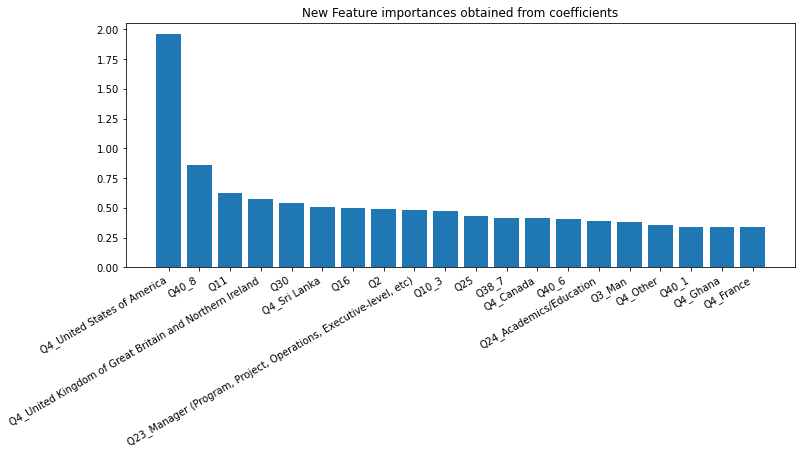

In [35]:
final_model = LogisticRegression(C = 10.0, solver ='lbfgs')
X = clean_new.drop(['Q29_Encoded'], axis = 1)
y = clean_new['Q29_Encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)   #30% test data, 70% tarin data
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

final_model.fit(X_train_scaled, y_train)
#cofficient means the effect of the features on salary bucket, take the absolute value, ignore the negative/posigtive
importances = pd.DataFrame(data={'Attribute': X_train.columns,'Importance': np.absolute(final_model.coef_[0])})
importances = importances.sort_values(by='Importance', ascending=False)  #sort in descending order

# plot new top 20 importance
fig = plt.figure(figsize=[12,5])
plt.bar(x=importances.iloc[:20,:]['Attribute'], height=importances.iloc[:20,:]['Importance'])
plt.title('New Feature importances obtained from coefficients', size=12)
fig.autofmt_xdate() 
plt.show()


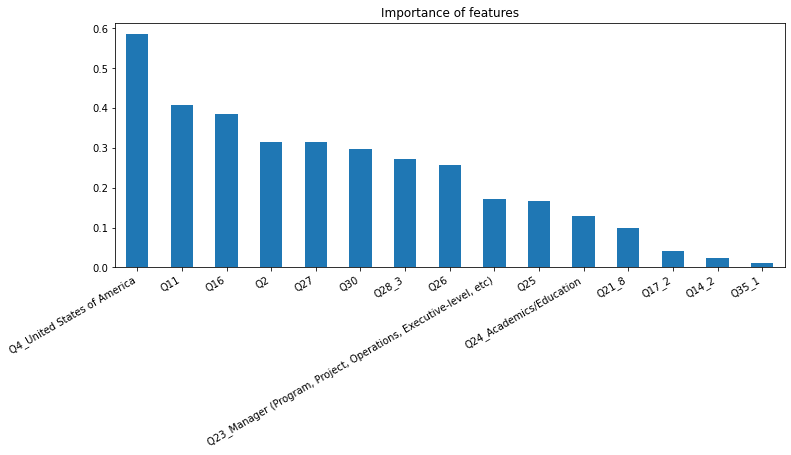

In [36]:
# original feature importance
fig_imp

# Part 5 Testing & Discussion
### use your optimal model to make classifications on the test set. How does your model perform on the test set vs. the training set?

In [51]:
from sklearn.metrics import f1_score
final_keep = importances.iloc[:20,:]['Attribute'].values
df_new = clean_new.loc[:,final_keep]     #select the top 20 important features
df_new['Q29_Encoded']= clean_new['Q29_Encoded']   #add the Q29_Encoded column
df_new

train_predict = get_predic(X_train, y_train, X_train, final_model)
f1_train= f1_score(y_train, train_predict, average='weighted')   #f1 score on training 
acc_train = accuracy_score(y_train, train_predict)   #accc on training
print ("For training dateset\nF1 Score:{}, accuracy:{}\n".format(f1_train,acc_train))
    
test_predic = get_predic(X_train, y_train, X_test, final_model)    #on validation
f1_test= f1_score(y_test, test_predic, average='weighted')
acc_test = accuracy_score(y_test, test_predic)
print ("For test dateset\nF1 Score:{}, accuracy:{}".format(f1_test,acc_test))

For training dateset
F1 Score:0.5254380622245552, accuracy:0.5550482879719052

For test dateset
F1 Score:0.359324782598311, accuracy:0.39451044653830397


### Plot the distribution of true target variable values and their predictions on both the training set and test set.
### Discussed in the report

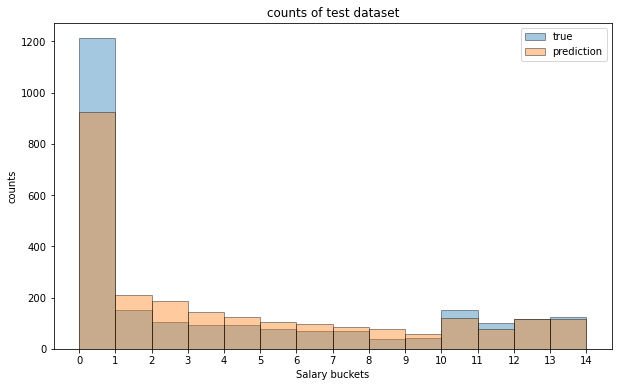


Descirption of the encoded salary


,salary bucket
encoded salary,
0.0,"0-9,999"
1.0,"10,000-19,999"
2.0,"20,000-29,999"
3.0,"30,000-39,999"
4.0,"40,000-49,999"
5.0,"50,000-59,999"
6.0,"60,000-69,999"
7.0,"70,000-79,999"
8.0,"80,000-89,999"


In [38]:
plt.figure(figsize = (10,6))
plt.hist(test_predic, bins = range(15), label = 'true',alpha = 0.4,edgecolor='black')  #distribution of true label 
plt.hist(y_test, bins = range(15), label = "prediction",alpha = 0.4,edgecolor='black')#distribution of predicted label 
plt.xlabel("Salary buckets")
plt.ylabel("counts")
plt.title("counts of test dataset")
plt.xticks(np.arange(0,15))
plt.legend()
plt.show()
print('\nDescirption of the encoded salary')
#display the  description of the encodede salary
salary_descrip = pd.DataFrame(salary_dic.items(),columns=['encoded salary', 'salary bucket'])
s = salary_descrip.sort_values(by='encoded salary')
s.set_index('encoded salary')